## Depth structure of heat budget terms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41483 instead
  warnings.warn(


In [5]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          17347073      base dask-wor smomw379  R       0:25      1 nesh-clk501


In [6]:
client

<Client: 'tcp://172.18.4.21:34375' processes=4 threads=32, memory=74.52 GiB>

In [7]:
def daily_clim(temp, doy): 

    ## for each day of the year get list of indices from full timeseries 
    doys = np.arange(doy-5,doy+6) # Hobday et al. (2016): take +- 5 days

    doys[doys<1]   = 366 + doys[doys<1] # include last/first days of year at beginning/end of year
    doys[doys>366] = doys[doys>366] - 366
    # get the indices in a sorted array
    ind_doy = np.array([])
    for xx in range(0,11):
      ind_doy = np.append(ind_doy, np.where(time_counter.dt.dayofyear == doys[xx])[0])
    ind_doy = np.sort(ind_doy).astype(int)

    ## temperature at doy from all years
    T_doy = temp.sel(time_counter=tsel).isel(time_counter=ind_doy)
    if doy==0:
      print(T_doy.time_counter[[0,-1]].values)

    ## average temperature for doy
    T_clim = T_doy.mean('time_counter').compute()

    ## standard deviation temperature for doy
    T_std = T_doy.std('time_counter').compute()

    return T_clim, T_std

### MHWs

In [8]:
## MHWs (detrended)
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'

MHW_detrend = np.zeros((15706, 46))

for zz in range(0,46):
    if zz<10:
        zr=f'0{zz}'
        MHW_detrend[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-{zr}.nc').mhw_mask
    else:
        MHW_detrend[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-{zz}.nc').mhw_mask

## ocean heat transport 

In [9]:
## load ocean heat transport
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHT = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHT-Tref_CapeVerde.nc', chunks={'time_counter':1})

In [10]:
## combine sections
OHT_net = (-dsOHT.OHT_E+dsOHT.OHT_W+dsOHT.OHT_S-dsOHT.OHT_N).compute()

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 9.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [11]:
OHT_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2009')
time_counter = dsOHT.time_counter.sel(time_counter=tsel)
for doy in range(0,366):
    OHT_clim[doy,:], OHT_std[doy,:] = daily_clim(OHT_net, doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']


In [12]:
## calculate anomaly from daily climatology
OHT_ano = np.zeros((15706,46)); 
tc=0

time_counter = dsOHT.time_counter

for yr in range(1980,2022+1):
    OHT_yr = OHT_net.groupby('time_counter.year')[yr]

    if len(OHT_yr)==366:
    
        OHT_ano[tc:tc+366,:] =  (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHT_ano[tc:tc+365,:] = (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim[0:-1,:].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHT_ano = xr.DataArray(OHT_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})

### vertical heat transport

In [13]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsWT = xr.open_mfdataset(path + f'1_VIKING20X.L46-KFS003-6th_1d_*_OHT-Tref-Vert_CapeVerde.nc')

In [14]:
OHT_Vert_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_Vert_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2009')
time_counter = dsWT.time_counter.sel(time_counter=tsel)

for doy in range(0,366):
    OHT_Vert_clim[doy,:], OHT_Vert_std[doy,:] = daily_clim(dsWT.OHT_vert, doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']


In [15]:
## anomaly from daily climatology
OHT_Vert_ano = np.zeros((15706,46)); 
tc=0

time_counter = dsWT.time_counter

for yr in range(1980,2022+1):
    OHT_Vert_yr = dsWT.OHT_vert.groupby('time_counter.year')[yr]
    OHT_Vert_yr = OHT_Vert_yr.chunk({'time_counter':len(OHT_Vert_yr.time_counter)})

    if len(OHT_Vert_yr)==366:
    
        OHT_Vert_ano[tc:tc+366,:] =  (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHT_Vert_ano[tc:tc+365,:] = (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHT_Vert_ano = xr.DataArray(OHT_Vert_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

### Horizontal and vertical temperature gradient

In [16]:
yCV = range(1002,1107)
xCV = range(1447,1532)

In [17]:
path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().rename({'z':'deptht'}).isel(x=xCV, y=yCV)
dpt = -dsM.nav_lev

In [18]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'
## temperature
dsT = xr.open_mfdataset(path + f'1_VIKING20X.L46-KFS003-6th_1y_*_grid_T.nc').isel(x=xCV, y=yCV)  

In [19]:
## vertical gradient
T_mn = dsT.votemper.where(dsT.votemper!=0).mean(('time_counter','x','y'))
T_grad_z = T_mn.diff('deptht').compute() / dsM.e3w_1d[1:]

In [20]:
yCVex = range(1002-50,1107+50)
xCVex = range(1447-50,1532+50)

## load mask
path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/'
dsM = xr.open_dataset(path+'1_mesh_mask.nc').isel(x=xCVex,y=yCVex).squeeze()

## temperature
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'
dsT = xr.open_mfdataset(path+f'1_VIKING20X.L46-KFS003-6th_1y_*_grid_T.nc'
                     ).isel(x=xCVex, y=yCVex)  

In [21]:
## horizontal gradient --> difference to volume integrated reference temperature 
T_mn = dsT.votemper.mean('time_counter').compute()
T_mn = T_mn.where(T_mn!=0)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 52.23 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [22]:
T_area = T_mn.mean(('x','y')).compute()


In [23]:
T_W = T_mn.isel(x=50,y=range(50,50+len(yCV)))
T_E = T_mn.isel(x=50+len(xCV), y=range(50,50+len(xCV)))
T_S = T_mn.isel(y=50, x=range(50,50+len(xCV))) 
T_N = T_mn.isel(y=50+len(yCV), x=range(50,50+len(xCV))) 

In [24]:
T_ano_W = ((T_W-T_area).mean('y'))
T_ano_E = ((T_E-T_area).mean('y'))
T_ano_S = ((T_S-T_area).mean('x'))
T_ano_N = ((T_N-T_area).mean('x'))

T_dif_h = (T_ano_W + T_ano_N + T_ano_S + T_ano_E)/4

## vertical transports

## lateral heat transport

## Plotting

In [25]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

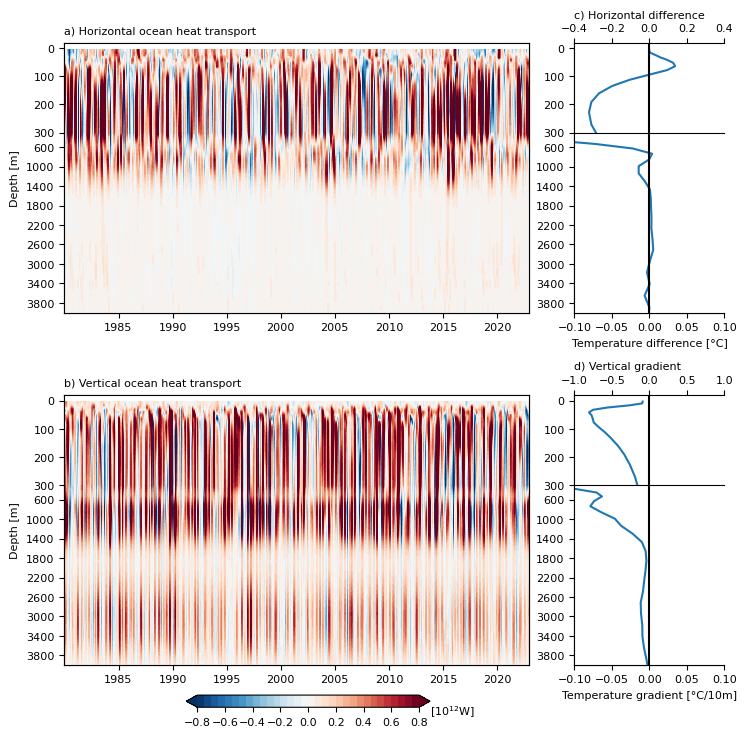

In [26]:
fig = plt.figure(figsize=(7.5,7.5))

axB = fig.add_axes([0.76,0.1,0.2,0.36]); axB.spines[['top','right']].set_visible(False); axB.set_yticks([]); axB.set_xticks([]);
axB1 = fig.add_axes([0.76,0.34,0.2,0.12], zorder=100); axB1.spines[['right']].set_visible(False); 
axB2 = fig.add_axes([0.76,0.1,0.2,0.24]); axB2.spines[['top','right']].set_visible(False); 

axA = fig.add_axes([0.76,0.57,0.2,0.36]); axA.spines[['top','right']].set_visible(False); axA.set_yticks([]); axA.set_xticks([]);
axA1 = fig.add_axes([0.76,0.81,0.2,0.12], zorder=100); axA1.spines[['right']].set_visible(False); # axA1.set_xticklabels([])
axA2 = fig.add_axes([0.76,0.57,0.2,0.24]); axA2.spines[['top','right']].set_visible(False);

ax1L = fig.add_axes([0.08,0.57,0.62,0.36]); ax1L.set_xticks([]); ax1L.set_yticks([]);
ax12 = fig.add_axes([0.08,0.57,0.62,0.24]); ax12.spines[['top']].set_visible(False); 
ax11 = fig.add_axes([0.08,0.81,0.62,0.12]); ax11.spines[['bottom']].set_visible(False); ax11.set_xticks([])

ax2L = fig.add_axes([0.08,0.1,0.62,0.36]); ax2L.set_xticks([]); ax2L.set_yticks([]);
ax22 = fig.add_axes([0.08,0.1,0.62,0.24]);  ax22.spines[['top']].set_visible(False);
ax21 = fig.add_axes([0.08,0.34,0.62,0.12]); ax21.spines[['bottom']].set_visible(False); ax21.set_xticks([])


##
axA1.plot(T_dif_h, dpt[:])
axA1.set_ylim(-300,20)
axA1.set_yticks(np.arange(-300,10,100)); axA1.set_yticklabels(np.arange(300,-10,-100))
axA1.set_xlim(-0.4,0.4)
axA1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axA2.plot(T_dif_h, dpt[:])
axA2.set_ylim(-4000,-300)
axA2.set_yticks(np.arange(-3800,-290,400)); axA2.set_yticklabels(np.arange(3800,310,-400))
axA2.set_xlim(-0.1,0.1)

axA1.vlines(0,-300,20, colors='k')
axA2.vlines(0,-4000,-300, colors='k')

axA1.set_title('c) Horizontal difference', loc='left', fontsize=8, pad=4)
axA2.set_xlabel('Temperature difference [°C]', fontsize=8)

##
axB1.plot(T_grad_z*10, dpt[:-1])
axB1.set_title('d) Vertical gradient', loc='left', fontsize=8, pad=4)
axB1.set_xlim(-1,1)
axB1.set_ylim(-300,20)
axB1.set_yticks(np.arange(-300,10,100)); axB1.set_yticklabels(np.arange(300,-10,-100))
axB1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

axB2.plot(T_grad_z*10, dpt[:-1])
axB2.set_xlim(-0.1,0.1)
axB2.set_ylim(-4000,-300)
axB2.set_yticks(np.arange(-3800,-290,400)); axB2.set_yticklabels(np.arange(3800,310,-400))
axB2.set_xlabel('Temperature gradient [°C/10m]', fontsize=8)

axB1.vlines(0,-300,20, colors='k')
axB2.vlines(0,-4000,-300, colors='k')

##
ax11.contourf(dsWT.time_counter, dpt, OHT_ano.T.rolling({'time_counter':60},center=True).mean()/1e12, levels=np.arange(-0.8,0.85,0.05), cmap='RdBu_r', extend='both')
ax11.set_title('a) Horizontal ocean heat transport', loc='left', fontsize=8)
ax11.set_yticks(np.arange(-300,10,100)); ax11.set_yticklabels(np.arange(300,-10,-100))
ax11.set_ylim(-300,20)

ax12.contourf(dsWT.time_counter, dpt, OHT_ano.T.rolling({'time_counter':60},center=True).mean()/1e12, levels=np.arange(-0.8,0.85,0.05), cmap='RdBu_r', extend='both')
ax12.set_ylim(-4000,-300)
ax12.set_yticks(np.arange(-3800,-290,400)); ax12.set_yticklabels(np.arange(3800,310,-400))

ax1L.set_ylabel('Depth [m]', fontsize=8, labelpad=32)


##
ctf = ax21.contourf(dsWT.time_counter, dpt, OHT_Vert_ano.T.rolling({'time_counter':60},center=True).mean()/1e12, levels=np.arange(-0.8,0.85,0.05), cmap='RdBu_r', extend='both')
ax21.set_title('b) Vertical ocean heat transport', loc='left', fontsize=8)
ax21.set_yticks(np.arange(-300,10,100)); ax21.set_yticklabels(np.arange(300,-10,-100))
ax21.set_ylim(-300,20)


ax22.contourf(dsWT.time_counter, dpt, OHT_Vert_ano.T.rolling({'time_counter':60},center=True).mean()/1e12, levels=np.arange(-0.8,0.85,0.05), cmap='RdBu_r', extend='both')
ax22.set_ylim(-4000,-300)
ax22.set_yticks(np.arange(-3800,-290,400)); ax22.set_yticklabels(np.arange(3800,310,-400))
ax2L.set_ylabel('Depth [m]', fontsize=8, labelpad=32)


axcb = fig.add_axes([0.08,0.,0.65,0.4], frameon=False); axcb.set_yticks([]); axcb.set_xticks([])
cb = plt.colorbar(ctf, ax=[axcb], orientation='horizontal', shrink=0.5)
cb.set_label(r'[10$^{12}$W]', x=1.15, labelpad=-17, fontsize=8)

plt.savefig('CapeVerde_Vert-Structure.png')

## Save data for publication

In [28]:
OHT_ano.attrs['long_name'] = 'Ocean heat transport anomaly'
OHT_ano.attrs['units'] = 'W'

OHT_Vert_ano.attrs['long_name'] = 'Vertical ocean heat transport anomaly'
OHT_Vert_ano.attrs['units'] = 'W'


T_dif_h.attrs['long_name'] = 'Horizontal temperature difference between interior and exterior of Cape Verde Archipelago'
T_dif_h.attrs['units'] = 'degC'

T_grad_z.attrs['long_name'] = 'Vertical temperature gradient in Cape Verde Archipelago'
T_grad_z.attrs['units'] = 'degC/m'

In [29]:
ds_out = xr.Dataset({'OHT_ano':OHT_ano, 'OHT_Vert_ano':OHT_Vert_ano, 'T_dif_hor':T_dif_h, 'T_vert_grad':T_grad_z})

In [30]:
ds_out

<xarray.Dataset> Size: 12MB
Dimensions:        (time_counter: 15706, deptht: 46)
Coordinates:
    time_centered  (time_counter) datetime64[ns] 126kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 126kB 1980-01-01T12:00:00 .....
  * deptht         (deptht) float32 184B 3.047 9.454 ... 5.625e+03 5.875e+03
Data variables:
    OHT_ano        (time_counter, deptht) float64 6MB -5.548e+11 ... 0.0
    OHT_Vert_ano   (time_counter, deptht) float64 6MB 5.519e+11 ... -0.0
    T_dif_hor      (deptht) float32 184B -0.001709 -0.001365 ... nan nan
    T_vert_grad    (deptht) float64 368B nan -0.009102 -0.009619 ... nan nan nan

In [31]:
## set global attributes
ds_out.attrs['title'] = 'Ocean heat transport and temperature gradients in the Cape Verde Archipelago'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 11_CapeVerde-MHW-Events-VertStructure.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-07-31'
ds_out.attrs['date_modified'] = '2025-07-31'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [32]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure11.nc')